In [1]:
import tensorflow.keras as k
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


import pandas as pd
import tensorflow as tf
import tensorflow.keras as k
import numpy as np

from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support, accuracy_score
from matplotlib import pyplot as plt

pd.set_option('display.max_columns', None)  # show all columns
GPUs = tf.config.list_physical_devices('GPU')
if GPUs is None or len(GPUs) == 0:
    print("WARNING: No GPU, all there is is:")
    for device in tf.config.list_physical_devices():
        print(f'- {device}')
else:
    for gpu in GPUs:
        tf.config.experimental.set_memory_growth(gpu, True)
        print("Initialized", gpu)

- PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')


In [2]:
def create_char_vectorizer(training_corpus):
    to_characters = k.preprocessing.text.Tokenizer(char_level=True, oov_token='<OOV>', filters='\t\n')
    to_characters.fit_on_texts(training_corpus)

    return to_characters


def create_word_vectorizer(training_corpus):
    word_vectorizer = CountVectorizer(
        stop_words=None,
        min_df=5,
        token_pattern=r'&\w+;|[:/&?=.\[\]\\]|%\w{2}|[-_\w\d]+',
        analyzer='word',
        max_features=500
    )
    word_vectorizer.fit(training_corpus)

    return word_vectorizer

def load_data(split_ratio=None, random_state=42):
    data = pd.read_csv("originalDataSet.csv")    #all_ita_final.csv
    data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
    if split_ratio is None:
        data_train = data_validation = None
    else:
        data_train, data_validation = train_test_split(
            data,
            test_size=split_ratio,
            stratify=data['Label'],
            shuffle=True,
            random_state=42
        )

    return data_train, data_validation, data

data_train, data_validation, data = load_data(split_ratio=0.3, random_state=42)

In [22]:
word_vectorizer = create_word_vectorizer(data_train['Domain'])
char_vectorizer = create_char_vectorizer(data_train['Domain'])
LC = len(char_vectorizer.word_counts)
LW = len(word_vectorizer.vocabulary_)

print('Char vocab size:', LC)
print('Word vocab size:', LW)

Char vocab size: 49
Word vocab size: 119


In [12]:
#This part is added to export data_train['Domain'] for prediction
from numpy import savetxt
savetxt('dataForVector.csv', data_train['Domain'], delimiter=',', fmt="%s")

In [4]:
def postpad_to(sequence, to):
    return k.preprocessing.sequence.pad_sequences(sequence, to, padding='post', truncating='post')

def map_text(X):
    if X[-1] == '/':
        X = X[:-1]
    return X

def create_dataset_generator(word_vectorizer, char_vectorizer, data: pd.DataFrame, one_hot=False, vec_length=200):
    assert word_vectorizer is not None or char_vectorizer is not None

    if word_vectorizer is not None:
        word_tokenizer = word_vectorizer.build_tokenizer()

    def gen():
        for row in data.iterrows():
            out_dict = dict()

            url = row[1].Domain
            _type = row[1].Label
            if one_hot:
                target = tf.squeeze(tf.one_hot([_type], depth=2))
            else:
                target = tf.squeeze(_type)

            if word_vectorizer is not None:
                wv = tf.constant(postpad_to(
                    [[word_vectorizer.vocabulary_.get(a, -1) + 2 for a in word_tokenizer(url)]]  # 0 = padding, 1 = OOV
                    , vec_length), name='word')
                out_dict['word'] = tf.squeeze(wv)

            if char_vectorizer is not None:
                cv = tf.constant(postpad_to(char_vectorizer.texts_to_sequences([url]), vec_length), name='char')
                out_dict['char'] = tf.squeeze(cv)

            yield out_dict, target

    output_types, output_shapes = dict(), dict()
    if word_vectorizer is not None:
        output_types['word'] = tf.float64
        output_shapes['word'] = tf.TensorShape([vec_length])
    if char_vectorizer is not None:
        output_types['char'] = tf.float64
        output_shapes['char'] = tf.TensorShape([vec_length])

    ds = tf.data.Dataset.from_generator(
        gen,
        output_types=(output_types, tf.int32),
        output_shapes=(output_shapes, tf.TensorShape([] if not one_hot else [2]))
    )

    return ds

In [5]:
dataset_train = create_dataset_generator(word_vectorizer, char_vectorizer, data_train)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)
dataset_validation = create_dataset_generator(word_vectorizer, char_vectorizer, data_validation)\
    .shuffle(10000)\
    .prefetch(10000) #.batch(15*1024)

print('Train:', dataset_train.element_spec, '\nValid:', dataset_validation.element_spec)

Train: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None)) 
Valid: ({'word': TensorSpec(shape=(200,), dtype=tf.float64, name=None), 'char': TensorSpec(shape=(200,), dtype=tf.float64, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 word (InputLayer)              [(None, 200)]        0           []                               
                                                                                                  
 char (InputLayer)              [(None, 200)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 200, 16)      1936        ['word[0][0]']                   
                                                                                                  
 embedding_1 (Embedding)        (None, 200, 16)      816         ['char[0][0]']                   
                                                                                              

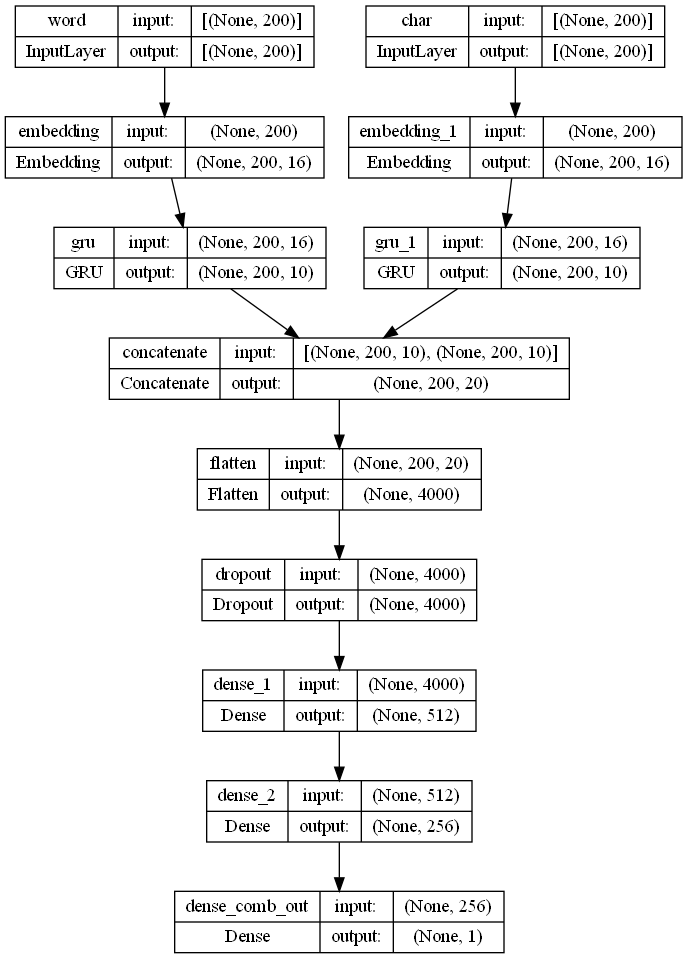

In [6]:
def create_url_net(input_length, emb_dim, gru_cells):
    word_input = k.layers.Input(shape=[input_length], name='word')
    char_input = k.layers.Input(shape=[input_length], name='char')

    x = k.layers.concatenate([
        k.layers.GRU(gru_cells, return_sequences=True)(k.layers.Embedding(2+LW, emb_dim, mask_zero=True)(word_input)),
        k.layers.GRU(gru_cells, return_sequences=True)(k.layers.Embedding(2+LC, emb_dim, mask_zero=True)(char_input)),
    ])
    x = k.layers.Flatten()(x)
    x = k.layers.Dropout(0.5, name=f'dropout')(x)
    x = k.layers.Dense(512, name=f'dense_1', activation='relu')(x)
    x = k.layers.Dense(256, name=f'dense_2', activation='relu')(x)
    x = k.layers.Dense(1, activation='sigmoid', name='dense_comb_out')(x)

    model = k.models.Model(inputs=[word_input, char_input], outputs=[x])
    return model

model = create_url_net(
    input_length=200,
    emb_dim=16,
    gru_cells=10,
)
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']#, k.metrics.Precision(), k.metrics.Recall()]
)
#     loss='binary_crossentropy',
model.summary()
k.utils.plot_model(model, show_shapes=True)

In [11]:
bs=256*16

model.fit(
    dataset_train.batch(bs),
    epochs=30,     #10
    validation_data=dataset_validation.batch(bs),
    callbacks=[
        k.callbacks.EarlyStopping(monitor='val_loss', patience=3),
        k.callbacks.ModelCheckpoint('./checkpoints', verbose=0)
    ],
)

Epoch 1/30
      1/Unknown - 3s 3s/step - loss: 0.6845 - binary_accuracy: 0.7497

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 41s 41s/step - loss: 0.6845 - binary_accuracy: 0.7497 - val_loss: 0.6749 - val_binary_accuracy: 0.7957
Epoch 2/30
1/1 [==============================] - ETA: 0s - loss: 0.6767 - binary_accuracy: 0.8025

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 43s 43s/step - loss: 0.6767 - binary_accuracy: 0.8025 - val_loss: 0.6662 - val_binary_accuracy: 0.8118
Epoch 3/30
1/1 [==============================] - ETA: 0s - loss: 0.6682 - binary_accuracy: 0.8152

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 43s 43s/step - loss: 0.6682 - binary_accuracy: 0.8152 - val_loss: 0.6573 - val_binary_accuracy: 0.8225
Epoch 4/30
1/1 [==============================] - ETA: 0s - loss: 0.6597 - binary_accuracy: 0.8266

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 41s 41s/step - loss: 0.6597 - binary_accuracy: 0.8266 - val_loss: 0.6482 - val_binary_accuracy: 0.8243
Epoch 5/30
1/1 [==============================] - ETA: 0s - loss: 0.6505 - binary_accuracy: 0.8331

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 44s 44s/step - loss: 0.6505 - binary_accuracy: 0.8331 - val_loss: 0.6385 - val_binary_accuracy: 0.8287
Epoch 6/30
1/1 [==============================] - ETA: 0s - loss: 0.6407 - binary_accuracy: 0.8408

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 44s 44s/step - loss: 0.6407 - binary_accuracy: 0.8408 - val_loss: 0.6282 - val_binary_accuracy: 0.8350
Epoch 7/30
1/1 [==============================] - ETA: 0s - loss: 0.6304 - binary_accuracy: 0.8419

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 41s 41s/step - loss: 0.6304 - binary_accuracy: 0.8419 - val_loss: 0.6173 - val_binary_accuracy: 0.8350
Epoch 8/30
1/1 [==============================] - ETA: 0s - loss: 0.6196 - binary_accuracy: 0.8511

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 42s 42s/step - loss: 0.6196 - binary_accuracy: 0.8511 - val_loss: 0.6056 - val_binary_accuracy: 0.8368
Epoch 9/30
1/1 [==============================] - ETA: 0s - loss: 0.6078 - binary_accuracy: 0.8580

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 43s 43s/step - loss: 0.6078 - binary_accuracy: 0.8580 - val_loss: 0.5931 - val_binary_accuracy: 0.8475
Epoch 10/30
1/1 [==============================] - ETA: 0s - loss: 0.5950 - binary_accuracy: 0.8626

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 42s 42s/step - loss: 0.5950 - binary_accuracy: 0.8626 - val_loss: 0.5799 - val_binary_accuracy: 0.8564
Epoch 11/30
1/1 [==============================] - ETA: 0s - loss: 0.5824 - binary_accuracy: 0.8676

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 47s 47s/step - loss: 0.5824 - binary_accuracy: 0.8676 - val_loss: 0.5659 - val_binary_accuracy: 0.8662
Epoch 12/30
1/1 [==============================] - ETA: 0s - loss: 0.5684 - binary_accuracy: 0.8791

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 46s 46s/step - loss: 0.5684 - binary_accuracy: 0.8791 - val_loss: 0.5513 - val_binary_accuracy: 0.8671
Epoch 13/30
1/1 [==============================] - ETA: 0s - loss: 0.5537 - binary_accuracy: 0.8848

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 40s 40s/step - loss: 0.5537 - binary_accuracy: 0.8848 - val_loss: 0.5360 - val_binary_accuracy: 0.8733
Epoch 14/30
1/1 [==============================] - ETA: 0s - loss: 0.5385 - binary_accuracy: 0.8909

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 41s 41s/step - loss: 0.5385 - binary_accuracy: 0.8909 - val_loss: 0.5200 - val_binary_accuracy: 0.8787
Epoch 15/30
1/1 [==============================] - ETA: 0s - loss: 0.5227 - binary_accuracy: 0.8925

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 45s 45s/step - loss: 0.5227 - binary_accuracy: 0.8925 - val_loss: 0.5034 - val_binary_accuracy: 0.8805
Epoch 16/30
1/1 [==============================] - ETA: 0s - loss: 0.5064 - binary_accuracy: 0.8990

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 42s 42s/step - loss: 0.5064 - binary_accuracy: 0.8990 - val_loss: 0.4863 - val_binary_accuracy: 0.8849
Epoch 17/30
1/1 [==============================] - ETA: 0s - loss: 0.4897 - binary_accuracy: 0.8974

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 41s 41s/step - loss: 0.4897 - binary_accuracy: 0.8974 - val_loss: 0.4690 - val_binary_accuracy: 0.8894
Epoch 18/30
1/1 [==============================] - ETA: 0s - loss: 0.4727 - binary_accuracy: 0.8990

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 48s 48s/step - loss: 0.4727 - binary_accuracy: 0.8990 - val_loss: 0.4515 - val_binary_accuracy: 0.8930
Epoch 19/30
1/1 [==============================] - ETA: 0s - loss: 0.4552 - binary_accuracy: 0.9009

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 46s 46s/step - loss: 0.4552 - binary_accuracy: 0.9009 - val_loss: 0.4339 - val_binary_accuracy: 0.8992
Epoch 20/30
1/1 [==============================] - ETA: 0s - loss: 0.4382 - binary_accuracy: 0.9024

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 42s 42s/step - loss: 0.4382 - binary_accuracy: 0.9024 - val_loss: 0.4163 - val_binary_accuracy: 0.9019
Epoch 21/30
1/1 [==============================] - ETA: 0s - loss: 0.4204 - binary_accuracy: 0.9051

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 42s 42s/step - loss: 0.4204 - binary_accuracy: 0.9051 - val_loss: 0.3988 - val_binary_accuracy: 0.9037
Epoch 22/30
1/1 [==============================] - ETA: 0s - loss: 0.4032 - binary_accuracy: 0.9055

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 51s 51s/step - loss: 0.4032 - binary_accuracy: 0.9055 - val_loss: 0.3815 - val_binary_accuracy: 0.9072
Epoch 23/30
1/1 [==============================] - ETA: 0s - loss: 0.3860 - binary_accuracy: 0.9070

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 44s 44s/step - loss: 0.3860 - binary_accuracy: 0.9070 - val_loss: 0.3645 - val_binary_accuracy: 0.9117
Epoch 24/30
1/1 [==============================] - ETA: 0s - loss: 0.3695 - binary_accuracy: 0.9078

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 45s 45s/step - loss: 0.3695 - binary_accuracy: 0.9078 - val_loss: 0.3479 - val_binary_accuracy: 0.9117
Epoch 25/30
1/1 [==============================] - ETA: 0s - loss: 0.3530 - binary_accuracy: 0.9085

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 45s 45s/step - loss: 0.3530 - binary_accuracy: 0.9085 - val_loss: 0.3318 - val_binary_accuracy: 0.9117
Epoch 26/30
1/1 [==============================] - ETA: 0s - loss: 0.3369 - binary_accuracy: 0.9097

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 44s 44s/step - loss: 0.3369 - binary_accuracy: 0.9097 - val_loss: 0.3162 - val_binary_accuracy: 0.9135
Epoch 27/30
1/1 [==============================] - ETA: 0s - loss: 0.3213 - binary_accuracy: 0.9124

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 64s 64s/step - loss: 0.3213 - binary_accuracy: 0.9124 - val_loss: 0.3011 - val_binary_accuracy: 0.9144
Epoch 28/30
1/1 [==============================] - ETA: 0s - loss: 0.3063 - binary_accuracy: 0.9124

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 45s 45s/step - loss: 0.3063 - binary_accuracy: 0.9124 - val_loss: 0.2866 - val_binary_accuracy: 0.9170
Epoch 29/30
1/1 [==============================] - ETA: 0s - loss: 0.2922 - binary_accuracy: 0.9131

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 46s 46s/step - loss: 0.2922 - binary_accuracy: 0.9131 - val_loss: 0.2727 - val_binary_accuracy: 0.9188
Epoch 30/30
1/1 [==============================] - ETA: 0s - loss: 0.2787 - binary_accuracy: 0.9143

INFO:tensorflow:Assets written to: .\checkpoints\assets


INFO:tensorflow:Assets written to: .\checkpoints\assets


1/1 [==============================] - 46s 46s/step - loss: 0.2787 - binary_accuracy: 0.9143 - val_loss: 0.2594 - val_binary_accuracy: 0.9197


In [13]:
model.save('30epoche')#recurrent

INFO:tensorflow:Assets written to: 30epoche\assets


INFO:tensorflow:Assets written to: 30epoche\assets


In [14]:
bs=256*16
model = k.models.load_model('30epoche')#recurrent

In [15]:
X_validation, y_validation = np.array([*dataset_validation.as_numpy_iterator()]).T
# X_validation = np.array([item['word'] for item in X_validation])
# X_validation = np.array([item['char'] for item in X_validation])
X_validation = np.array([(item['word'],item['char']) for item in X_validation])
X_validation = tf.data.Dataset.from_tensor_slices(((X_validation[:,0,:], X_validation[:,1,:]), )).batch(bs)
y_validation = y_validation.astype('int32')

y_hat = model.predict(X_validation).ravel()

1/1 [==============================] - 3s 3s/step


In [16]:
fpr, tpr, thresholds = roc_curve(y_validation, y_hat)
auc_ = auc(fpr, tpr)
best_threshold = thresholds[np.argmax(-fpr + tpr)]

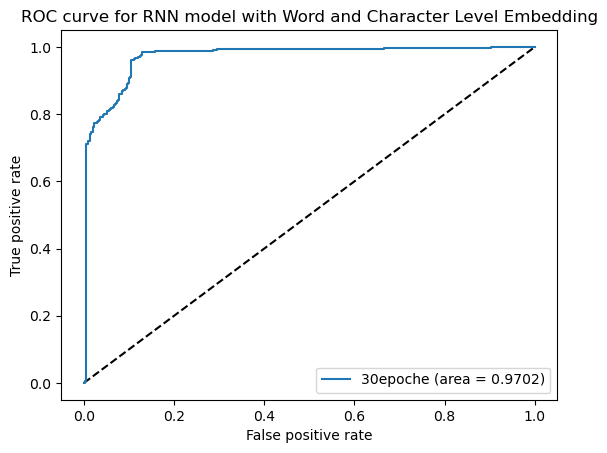

In [17]:
model_name = "30epoche"
model_full_name = "RNN model with Word and Character Level Embedding"

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label=f'{model_name} (area = {auc_:.4f})')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f'ROC curve for {model_full_name}')
plt.legend(loc='best')
plt.savefig(f'./{model_name.replace(" ", "_").lower()}_roc.pdf')
plt.show()

In [18]:
y_hat_01 = np.zeros_like(y_hat)
y_hat_01[y_hat >= best_threshold] = 1

np.unique(y_hat_01)

array([0., 1.], dtype=float32)

In [19]:
precision_recall_fscore_support(y_validation, y_hat_01, beta=1, average='binary'), \
    tpr[np.argmax(-fpr + tpr)], fpr[np.argmax(-fpr + tpr)], \
    accuracy_score(y_validation, y_hat_01)

((0.8846153846153846, 0.9857142857142858, 0.9324324324324325, None),
 0.9857142857142858,
 0.12834224598930483,
 0.928635147190009)

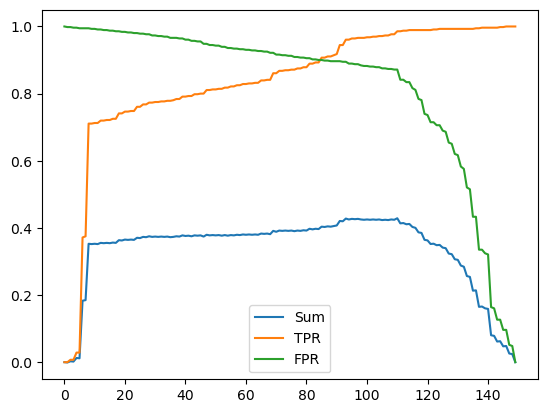

In [20]:
plt.plot((-fpr + tpr) / 2, label='Sum')
plt.plot(tpr, label='TPR')
plt.plot(1-fpr, label='FPR')
plt.legend()